# Plot the Decadal Trends in Key Climate Variables

## 1. Import required Python libraries

In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import LC_Grid_Labels as lc
import cartopy
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import wrf
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import IPython

### 1. a. Print session and library version numbers  

In [2]:
# Print IPython Session Info
print(IPython.sys_info())

# Print versions of libraries used in this notebook for traceability
print("\nPackage version numbers:\n")
print("xarray version: " + xr.__version__)
print("numpy version: " + np.__version__)
print("scipy version: " + scipy.__version__)
print("matplotlib version: " + matplotlib.__version__)
print("cartopy: " + cartopy.__version__)
print("wrf-python version: " + wrf.__version__+"\n")

{'commit_hash': '8c47bbcb3',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/Users/lejoflores/miniconda3/lib/python3.7/site-packages/IPython',
 'ipython_version': '7.5.0',
 'os_name': 'posix',
 'platform': 'Darwin-18.6.0-x86_64-i386-64bit',
 'sys_executable': '/Users/lejoflores/miniconda3/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.7.3 (default, Mar 27 2019, 16:54:48) \n'
                '[Clang 4.0.1 (tags/RELEASE_401/final)]'}

Package version numbers:

xarray version: 0.12.1
numpy version: 1.16.3
scipy version: 1.2.1
matplotlib version: 3.0.3
cartopy: 0.17.0
wrf-python version: 1.3.2



## 2. Read in the data using ```xarray```

In [3]:
wrf_dir = '/Users/lejoflores/data/WRF-NARR-1km-Daily/'

ds_wrf = xr.open_mfdataset(wrf_dir+'WRF-NARR*.nc')
ds_wrf

<xarray.Dataset>
Dimensions:  (XTIME: 10958, south_north: 327, west_east: 348)
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 1987-10-01 1987-10-02 ... 2017-09-30
Dimensions without coordinates: south_north, west_east
Data variables:
    DPRCP    (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMEAN    (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    Q2       (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    SWDOWN   (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    SWNORM   (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMIN     (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMAX     (XTIME, south_north, west_east) float32 dask.array<shap

## 2. a. Create a month of the water year array to use as a grouping variable

In [4]:
WY1 = (ds_wrf['XTIME.year'].where(ds_wrf['XTIME.month'] >= 10).values + 1)
WY2 = (ds_wrf['XTIME.year'].where(ds_wrf['XTIME.month'] < 10).values)
WY = np.nansum(np.column_stack((WY1,WY2)),axis=1)

WY_MO = ds_wrf['XTIME.month'].values - 9
WY_MO[WY_MO<=0] += 12

## 2. b. Add the month of water year array to the dataset

In [5]:
ds_wrf.coords['WY'] = xr.DataArray(WY.astype(int),dims='XTIME')
ds_wrf.coords['WY_MO'] = xr.DataArray(WY_MO.astype(int),dims='XTIME')
ds_wrf

<xarray.Dataset>
Dimensions:  (XTIME: 10958, south_north: 327, west_east: 348)
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 1987-10-01 1987-10-02 ... 2017-09-30
    WY       (XTIME) int64 1988 1988 1988 1988 1988 ... 2017 2017 2017 2017 2017
    WY_MO    (XTIME) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12
Dimensions without coordinates: south_north, west_east
Data variables:
    DPRCP    (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMEAN    (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    Q2       (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    SWDOWN   (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    SWNORM   (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMIN     (XTIME, s

# 3. Get decadal averages
## 3. a. Get average annual precipitation for first and third decades

In [6]:
decade1 = ds_wrf.sel(XTIME=slice('1987-10-01','1997-09-30'))
decade3 = ds_wrf.sel(XTIME=slice('2008-10-01','2017-09-30'))

In [7]:
dprcp_decade1_OND = decade1.DPRCP[decade1.WY_MO.values<=3].groupby('WY').sum(dim='XTIME').mean(dim='WY')
dprcp_decade1_JFM = decade1.DPRCP[(decade1.WY_MO.values > 3) & (decade1.WY_MO.values <= 6)].groupby('WY').sum(dim='XTIME').mean(dim='WY')
dprcp_decade1_AMJ = decade1.DPRCP[(decade1.WY_MO.values > 6) & (decade1.WY_MO.values <= 9)].groupby('WY').sum(dim='XTIME').mean(dim='WY')
dprcp_decade1_JAS = decade1.DPRCP[decade1.WY_MO.values > 9].groupby('WY').sum(dim='XTIME').mean(dim='WY')

dprcp_decade3_OND = decade3.DPRCP[decade3.WY_MO.values<=3].groupby('WY').sum(dim='XTIME').mean(dim='WY')
dprcp_decade3_JFM = decade3.DPRCP[(decade3.WY_MO.values > 3) & (decade3.WY_MO.values <= 6)].groupby('WY').sum(dim='XTIME').mean(dim='WY')
dprcp_decade3_AMJ = decade3.DPRCP[(decade3.WY_MO.values > 6) & (decade3.WY_MO.values <= 9)].groupby('WY').sum(dim='XTIME').mean(dim='WY')
dprcp_decade3_JAS = decade3.DPRCP[decade3.WY_MO.values > 9].groupby('WY').sum(dim='XTIME').mean(dim='WY')


In [8]:
tmin_decade1_OND = decade1.TMIN[decade1.WY_MO.values<=3].groupby('WY').mean(dim='XTIME').mean(dim='WY')
tmin_decade1_JFM = decade1.TMIN[(decade1.WY_MO.values > 3) & (decade1.WY_MO.values <= 6)].groupby('WY').mean(dim='XTIME').mean(dim='WY')
tmin_decade1_AMJ = decade1.TMIN[(decade1.WY_MO.values > 6) & (decade1.WY_MO.values <= 9)].groupby('WY').mean(dim='XTIME').mean(dim='WY')
tmin_decade1_JAS = decade1.TMIN[decade1.WY_MO.values > 9].groupby('WY').mean(dim='XTIME').mean(dim='WY')

tmin_decade3_OND = decade3.TMIN[decade3.WY_MO.values<=3].groupby('WY').mean(dim='XTIME').mean(dim='WY')
tmin_decade3_JFM = decade3.TMIN[(decade3.WY_MO.values > 3) & (decade3.WY_MO.values <= 6)].groupby('WY').mean(dim='XTIME').mean(dim='WY')
tmin_decade3_AMJ = decade3.TMIN[(decade3.WY_MO.values > 6) & (decade3.WY_MO.values <= 9)].groupby('WY').mean(dim='XTIME').mean(dim='WY')
tmin_decade3_JAS = decade3.TMIN[decade3.WY_MO.values > 9].groupby('WY').mean(dim='XTIME').mean(dim='WY')


In [9]:
tmax_decade1_OND = decade1.TMAX[decade1.WY_MO.values<=3].groupby('WY').mean(dim='XTIME').mean(dim='WY')
tmax_decade1_JFM = decade1.TMAX[(decade1.WY_MO.values > 3) & (decade1.WY_MO.values <= 6)].groupby('WY').mean(dim='XTIME').mean(dim='WY')
tmax_decade1_AMJ = decade1.TMAX[(decade1.WY_MO.values > 6) & (decade1.WY_MO.values <= 9)].groupby('WY').mean(dim='XTIME').mean(dim='WY')
tmax_decade1_JAS = decade1.TMAX[decade1.WY_MO.values > 9].groupby('WY').mean(dim='XTIME').mean(dim='WY')

tmax_decade3_OND = decade3.TMAX[decade3.WY_MO.values<=3].groupby('WY').mean(dim='XTIME').mean(dim='WY')
tmax_decade3_JFM = decade3.TMAX[(decade3.WY_MO.values > 3) & (decade3.WY_MO.values <= 6)].groupby('WY').mean(dim='XTIME').mean(dim='WY')
tmax_decade3_AMJ = decade3.TMAX[(decade3.WY_MO.values > 6) & (decade3.WY_MO.values <= 9)].groupby('WY').mean(dim='XTIME').mean(dim='WY')
tmax_decade3_JAS = decade3.TMAX[decade3.WY_MO.values > 9].groupby('WY').mean(dim='XTIME').mean(dim='WY')


# 4. Plot results
### 4. a. Prepare a few plotting variables used across plots

In [10]:
ds_wrfgeo = xr.open_dataset(wrf_dir+'wrf_geoinfo.nc')
nc_wrfgeo = nc.Dataset(wrf_dir+'wrf_geoinfo.nc')
cart_proj = get_cartopy(wrfin=nc_wrfgeo)

lats, lons = latlon_coords(ds_wrfgeo)

lat = lats[0]
lon = lons[0]

states = NaturalEarthFeature(category='cultural', scale='10m',facecolor='none',name='admin_1_states_provinces_shp')
rivers = NaturalEarthFeature(category='physical',scale='10m',facecolor='none',name='rivers_lake_centerlines')

plt.rcParams.update({'font.size': 9, 'font.family':'sans-serif'})

xticks = [-118,-117,-116,-115,-114,-113]
yticks = [42,43,44,45,46]

fig_ids = ['(a) WY 1988-1997 OND','(b) WY 2008-2017 OND','(c) Difference OND',
           '(d) WY 1988-1997 JFM','(e) WY 2008-2017 JFM','(f) Difference JFM',
           '(g) WY 1988-1997 AMJ','(h) WY 2008-2017 AMJ','(i) Difference AMJ',
           '(j) WY 1988-1997 JAS','(k) WY 2008-2017 JAS','(l) Difference JAS']

figsize_in = (12.5,13)
figres_dpi = 300
figext = '.tif'

contour_levels = 15

PrecipChange_fname = 'fig/8_PrcpDecadalChange.tif'
TminChange_fname = 'fig/9_TminDecadalChange.tif'
TmaxChange_fname = 'fig/10_TmaxDecadalChange.tif'

### 4. b. Plot precipitation change between first and last decades by season

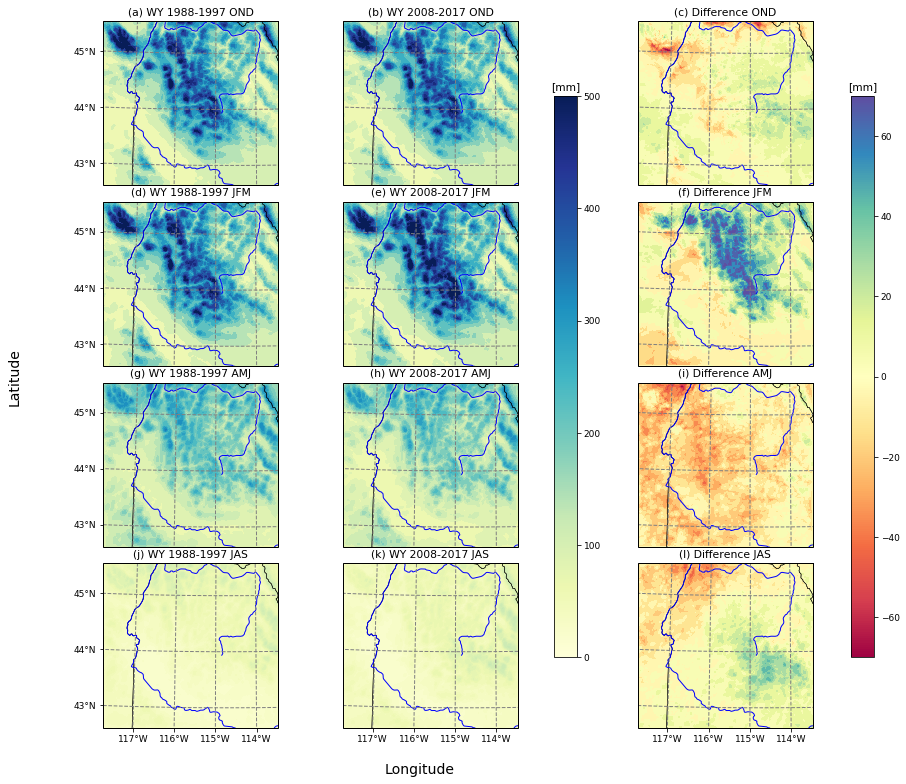

In [11]:
vmin_prcp = 0.0
vmax_prcp = 500.0
vmin_dprcp = -70.0
vmax_dprcp = 70.0

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=figsize_in, subplot_kw = {'projection': cart_proj})
fig.subplots_adjust(wspace = .1, hspace = .1)

im11 = axes[0][0].contourf(to_np(lon),to_np(lat),dprcp_decade1_OND,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='YlGnBu')
im12 = axes[0][1].contourf(to_np(lon),to_np(lat),dprcp_decade3_OND,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='YlGnBu')
im13 = axes[0][2].contourf(to_np(lon),to_np(lat),dprcp_decade3_OND - dprcp_decade1_OND,contour_levels,
                           transform=crs.PlateCarree(),vmin=vmin_dprcp,vmax=vmax_dprcp,cmap='Spectral')

im21 = axes[1][0].contourf(to_np(lon),to_np(lat),dprcp_decade1_JFM,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='YlGnBu')
im22 = axes[1][1].contourf(to_np(lon),to_np(lat),dprcp_decade3_JFM,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='YlGnBu')
im23 = axes[1][2].contourf(to_np(lon),to_np(lat),dprcp_decade3_JFM - dprcp_decade1_JFM,contour_levels,
                           transform=crs.PlateCarree(),vmin=vmin_dprcp,vmax=vmax_dprcp,cmap='Spectral')

im31 = axes[2][0].contourf(to_np(lon),to_np(lat),dprcp_decade1_AMJ,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='YlGnBu')
im32 = axes[2][1].contourf(to_np(lon),to_np(lat),dprcp_decade3_AMJ,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='YlGnBu')
im33 = axes[2][2].contourf(to_np(lon),to_np(lat),dprcp_decade3_AMJ - dprcp_decade1_AMJ,contour_levels,
                           transform=crs.PlateCarree(),vmin=vmin_dprcp,vmax=vmax_dprcp,cmap='Spectral')

im41 = axes[3][0].contourf(to_np(lon),to_np(lat),dprcp_decade1_JAS,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='YlGnBu')
im42 = axes[3][1].contourf(to_np(lon),to_np(lat),dprcp_decade3_JAS,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='YlGnBu')
im43 = axes[3][2].contourf(to_np(lon),to_np(lat),dprcp_decade3_JAS - dprcp_decade1_JAS,contour_levels,
                           transform=crs.PlateCarree(),vmin=vmin_dprcp,vmax=vmax_dprcp,cmap='Spectral')

FigIter = 0
for ax in axes.flat:
    ax.add_feature(states, linewidth=0.5, edgecolor='black')
    ax.add_feature(rivers, linewidth=1.0, edgecolor='b')
    fig.canvas.draw()
    ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', linestyle='--', linewidth=1)
    ax.set_title(fig_ids[FigIter])
    
    if(ax.rowNum==3):
        ax.xaxis.set_major_formatter(lc.LONGITUDE_FORMATTER) 
        lc.lambert_xticks(ax, xticks)
    
    if(ax.colNum==0):
        ax.yaxis.set_major_formatter(lc.LATITUDE_FORMATTER)
        lc.lambert_yticks(ax, yticks)

    if(ax.colNum==2):
        pos = ax.get_position()
        pos.x0 += 0.05
        ax.set_position([pos.x0,pos.y0,pos.width*1.5,pos.height])
    FigIter += 1
    
fig.text(0.5, 0.08, 'Longitude', ha='center', va='center', fontsize=14)
fig.text(0.05, 0.5, 'Latitude', ha='center', va='center', rotation='vertical', fontsize=14)

cbar_ax1 = fig.add_axes([0.65, 0.2, 0.025, 0.6],in_layout=False)

m = plt.cm.ScalarMappable(cmap=cm.YlGnBu)
m.set_array(to_np(dprcp_decade1_OND))
m.set_clim(vmin_prcp, vmax_prcp)

clb1 = fig.colorbar(m,cax = cbar_ax1)
clb1.ax.set_title('[mm]')

cbar_ax2 = fig.add_axes([0.98, 0.2, 0.025, 0.6],in_layout=False)

m = plt.cm.ScalarMappable(cmap=cm.Spectral)
m.set_array(to_np(dprcp_decade3_OND - dprcp_decade1_OND))
m.set_clim(vmin_dprcp, vmax_dprcp)

clb2 = fig.colorbar(m,cax = cbar_ax2)
clb2.ax.set_title('[mm]')

plt.savefig(PrecipChange_fname, dpi=figres_dpi, facecolor='w', edgecolor='w', 
            orientation='portrait', bbox_inches='tight')

### 4. c. Plot daily minimum temperature change between first and last decades by season

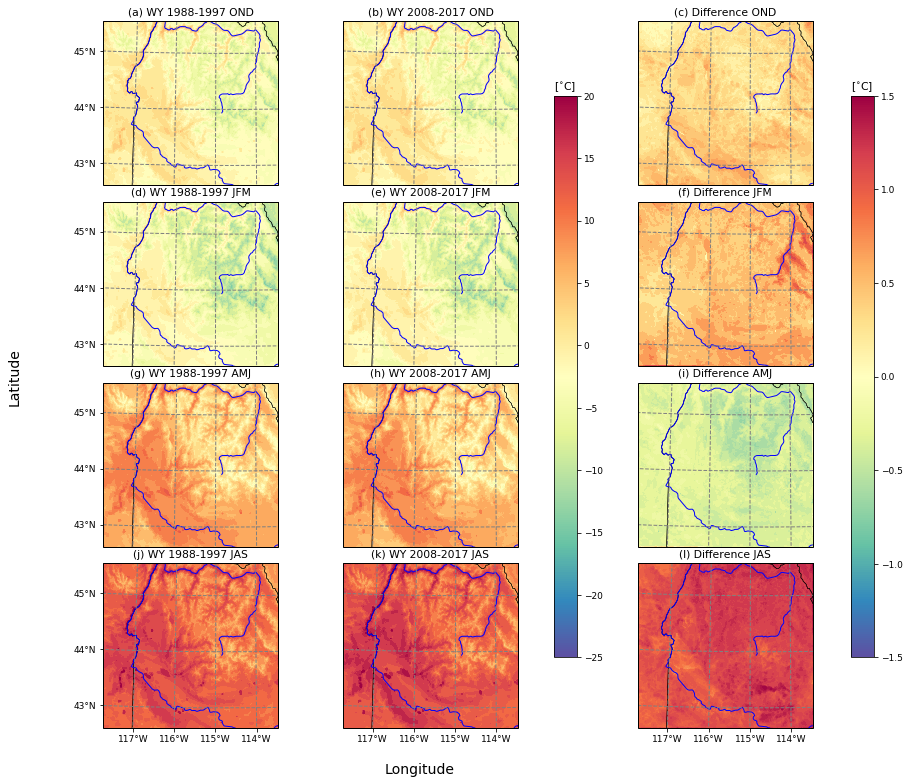

In [12]:
vmin_tmin = -25.0
vmax_tmin = 20.0
vmin_dtmin = -1.5
vmax_dtmin = 1.5

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=figsize_in, subplot_kw = {'projection': cart_proj})
fig.subplots_adjust(wspace = .1, hspace = .1)

im11 = axes[0][0].contourf(to_np(lon),to_np(lat),(tmin_decade1_OND - 273.15),contour_levels,
                           transform=crs.PlateCarree(),vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')
im12 = axes[0][1].contourf(to_np(lon),to_np(lat),(tmin_decade3_OND - 273.15),contour_levels,
                           transform=crs.PlateCarree(),vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')
im13 = axes[0][2].contourf(to_np(lon),to_np(lat),(tmin_decade3_OND - tmin_decade1_OND),
                           contour_levels,transform=crs.PlateCarree(),vmin=vmin_dtmin,vmax=vmax_dtmin,cmap='Spectral_r')

im21 = axes[1][0].contourf(to_np(lon),to_np(lat),(tmin_decade1_JFM - 273.15),contour_levels,
                           transform=crs.PlateCarree(),vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')
im22 = axes[1][1].contourf(to_np(lon),to_np(lat),(tmin_decade3_JFM - 273.15),contour_levels,
                           transform=crs.PlateCarree(),vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')
im23 = axes[1][2].contourf(to_np(lon),to_np(lat),(tmin_decade3_JFM - tmin_decade1_JFM),
                           contour_levels,transform=crs.PlateCarree(),vmin=vmin_dtmin,vmax=vmax_dtmin,cmap='Spectral_r')

im31 = axes[2][0].contourf(to_np(lon),to_np(lat),(tmin_decade1_AMJ - 273.15),contour_levels,
                           transform=crs.PlateCarree(),vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')
im32 = axes[2][1].contourf(to_np(lon),to_np(lat),(tmin_decade3_AMJ - 273.15),contour_levels,
                           transform=crs.PlateCarree(),vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')
im33 = axes[2][2].contourf(to_np(lon),to_np(lat),(tmin_decade3_AMJ - tmin_decade1_AMJ),
                           contour_levels,transform=crs.PlateCarree(),vmin=vmin_dtmin,vmax=vmax_dtmin,cmap='Spectral_r')

im41 = axes[3][0].contourf(to_np(lon),to_np(lat),(tmin_decade1_JAS - 273.15),contour_levels,
                           transform=crs.PlateCarree(),vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')
im42 = axes[3][1].contourf(to_np(lon),to_np(lat),(tmin_decade3_JAS - 273.15),contour_levels,
                           transform=crs.PlateCarree(),vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')
im43 = axes[3][2].contourf(to_np(lon),to_np(lat),(tmin_decade3_JAS - tmin_decade1_JAS),
                           contour_levels,transform=crs.PlateCarree(),vmin=vmin_dtmin,vmax=vmax_dtmin,cmap='Spectral_r')

FigIter = 0
for ax in axes.flat:
    ax.add_feature(states, linewidth=0.5, edgecolor='black')
    ax.add_feature(rivers, linewidth=1.0, edgecolor='b')
    fig.canvas.draw()
    ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', linestyle='--', linewidth=1)
    ax.set_title(fig_ids[FigIter])
    
    if(ax.rowNum==3):
        ax.xaxis.set_major_formatter(lc.LONGITUDE_FORMATTER) 
        lc.lambert_xticks(ax, xticks)
    
    if(ax.colNum==0):
        ax.yaxis.set_major_formatter(lc.LATITUDE_FORMATTER)
        lc.lambert_yticks(ax, yticks)

    if(ax.colNum==2):
        pos = ax.get_position()
        pos.x0 += 0.05
        ax.set_position([pos.x0,pos.y0,pos.width*1.5,pos.height])
    FigIter += 1
    
fig.text(0.5, 0.08, 'Longitude', ha='center', va='center', fontsize=14)
fig.text(0.05, 0.5, 'Latitude', ha='center', va='center', rotation='vertical', fontsize=14)

cbar_ax1 = fig.add_axes([0.65, 0.2, 0.025, 0.6],in_layout=False)

m = plt.cm.ScalarMappable(cmap=cm.Spectral_r)
m.set_array(to_np(tmin_decade1_OND - 273.15))
m.set_clim(vmin_tmin, vmax_tmin)

clb1 = fig.colorbar(m,cax = cbar_ax1)
clb1.ax.set_title('[${}^{\circ}$C]')

cbar_ax2 = fig.add_axes([0.98, 0.2, 0.025, 0.6],in_layout=False)

m = plt.cm.ScalarMappable(cmap=cm.Spectral_r)
m.set_array(to_np(tmin_decade3_OND - tmin_decade1_OND))
m.set_clim(vmin_dtmin, vmax_dtmin)

clb2 = fig.colorbar(m,cax = cbar_ax2)
clb2.ax.set_title('[${}^{\circ}$C]')

plt.savefig(TminChange_fname, dpi=figres_dpi, facecolor='w', edgecolor='w', 
            orientation='portrait', bbox_inches='tight')

### 4. d. Plot daily maximum temperature change between first and last decades by season

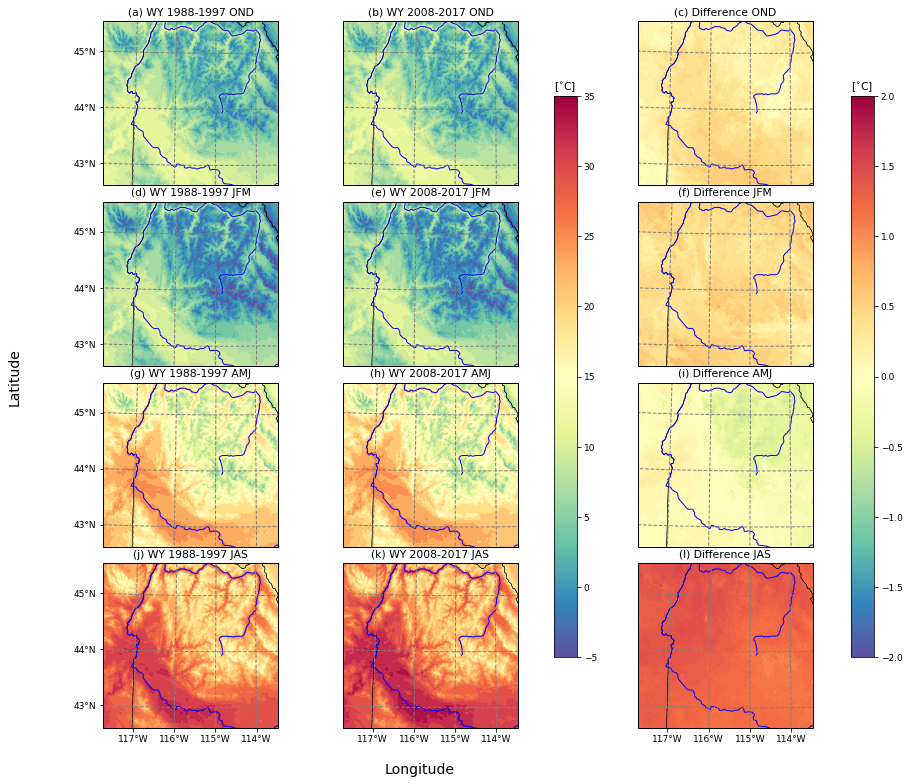

In [13]:
vmin_tmax = -5.0
vmax_tmax = 35.0
vmin_dtmax = -2.0
vmax_dtmax = 2.0

fig, axes = plt.subplots(ncols=3, nrows=4, figsize=figsize_in, subplot_kw = {'projection': cart_proj})
fig.subplots_adjust(wspace = .1, hspace = .1)

im11 = axes[0][0].contourf(to_np(lon),to_np(lat),tmax_decade1_OND - 273.15,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmax,vmax=vmax_tmax,cmap='Spectral_r')
im12 = axes[0][1].contourf(to_np(lon),to_np(lat),tmax_decade3_OND - 273.15,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmax,vmax=vmax_tmax,cmap='Spectral_r')
im13 = axes[0][2].contourf(to_np(lon),to_np(lat),(tmax_decade3_OND - tmax_decade1_OND),contour_levels,
                           transform=crs.PlateCarree(),vmin=vmin_dtmax,vmax=vmax_dtmax,cmap='Spectral_r')

im21 = axes[1][0].contourf(to_np(lon),to_np(lat),tmax_decade1_JFM - 273.15,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmax,vmax=vmax_tmax,cmap='Spectral_r')
im22 = axes[1][1].contourf(to_np(lon),to_np(lat),tmax_decade3_JFM - 273.15,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmax,vmax=vmax_tmax,cmap='Spectral_r')
im23 = axes[1][2].contourf(to_np(lon),to_np(lat),(tmax_decade3_JFM - tmax_decade1_JFM),contour_levels,
                           transform=crs.PlateCarree(),vmin=vmin_dtmax,vmax=vmax_dtmax,cmap='Spectral_r')

im31 = axes[2][0].contourf(to_np(lon),to_np(lat),tmax_decade1_AMJ - 273.15,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmax,vmax=vmax_tmax,cmap='Spectral_r')
im32 = axes[2][1].contourf(to_np(lon),to_np(lat),tmax_decade3_AMJ - 273.15,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmax,vmax=vmax_tmax,cmap='Spectral_r')
im33 = axes[2][2].contourf(to_np(lon),to_np(lat),(tmax_decade3_AMJ - tmax_decade1_AMJ),contour_levels,
                           transform=crs.PlateCarree(),vmin=vmin_dtmax,vmax=vmax_dtmax,cmap='Spectral_r')

im41 = axes[3][0].contourf(to_np(lon),to_np(lat),tmax_decade1_JAS - 273.15,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmax,vmax=vmax_tmax,cmap='Spectral_r')
im42 = axes[3][1].contourf(to_np(lon),to_np(lat),tmax_decade3_JAS - 273.15,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmax,vmax=vmax_tmax,cmap='Spectral_r')
im43 = axes[3][2].contourf(to_np(lon),to_np(lat),(tmax_decade3_JAS - tmax_decade1_JAS),contour_levels,
                           transform=crs.PlateCarree(),vmin=vmin_dtmax,vmax=vmax_dtmax,cmap='Spectral_r')

FigIter = 0
for ax in axes.flat:
    ax.add_feature(states, linewidth=0.5, edgecolor='black')
    ax.add_feature(rivers, linewidth=1.0, edgecolor='b')
    fig.canvas.draw()
    ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', linestyle='--', linewidth=1)
    ax.set_title(fig_ids[FigIter])
    
    if(ax.rowNum==3):
        ax.xaxis.set_major_formatter(lc.LONGITUDE_FORMATTER) 
        lc.lambert_xticks(ax, xticks)
    
    if(ax.colNum==0):
        ax.yaxis.set_major_formatter(lc.LATITUDE_FORMATTER)
        lc.lambert_yticks(ax, yticks)

    if(ax.colNum==2):
        pos = ax.get_position()
        pos.x0 += 0.05
        ax.set_position([pos.x0,pos.y0,pos.width*1.5,pos.height])
    FigIter += 1
    
fig.text(0.5, 0.08, 'Longitude', ha='center', va='center', fontsize=14)
fig.text(0.05, 0.5, 'Latitude', ha='center', va='center', rotation='vertical', fontsize=14)

cbar_ax1 = fig.add_axes([0.65, 0.2, 0.025, 0.6],in_layout=False)

m = plt.cm.ScalarMappable(cmap=cm.Spectral_r)
m.set_array(to_np(tmax_decade1_OND - 273.15))
m.set_clim(vmin_tmax, vmax_tmax)

clb1 = fig.colorbar(m,cax = cbar_ax1)
clb1.ax.set_title('[${}^{\circ}$C]')

cbar_ax2 = fig.add_axes([0.98, 0.2, 0.025, 0.6],in_layout=False)

m = plt.cm.ScalarMappable(cmap=cm.Spectral_r)
m.set_array(to_np(tmax_decade3_OND - tmax_decade1_OND))
m.set_clim(vmin_dtmax, vmax_dtmax)

clb2 = fig.colorbar(m,cax = cbar_ax2)
clb2.ax.set_title('[${}^{\circ}$C]')

plt.savefig(TmaxChange_fname, dpi=figres_dpi, facecolor='w', edgecolor='w', 
            orientation='portrait', bbox_inches='tight')